# 注意力评分函数



In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

掩蔽softmax操作

In [2]:
'''
X：输入张量，形状可能是(batch_size,seq_len)或(batch_size,seq_len,seq_len)
valid_lens：每个样本的有效长度（整数列表），如 [3,4,2] 表示3个样本的有效长度分别为3、4、2
dim=-1：最后一个维度
dim=-2：倒数第二个维度
dim=0：第一个维度
'''
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # 分支1：无掩蔽（标准softmax）
    if valid_lens is None:
        # dim=-1 表示在最后一个轴（维度）上执行softmax操作
        return nn.functional.softmax(X, dim=-1)
    # 分支2：带掩蔽的softmax
    else:
        # 步骤1：展平valid_lens
        shape = X.shape # 保存原始形状
        if valid_lens.dim() == 1:
            # # 示例: valid_lens=[3,4], shape[1]=5→重复为 [3,3,3,3,3,4,4,4,4,4]
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1) # 展平为一维
        # 步骤2：应用掩码：将多维输入展平为二维，同时保留最后一个维度不变
        # sequence_mask：将无效位置填充为-1e6（极大负数）。原理：softmax中exp(-1e6)≈0，这些位置权重变为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        # 步骤3：恢复形状并执行softmax
        return nn.functional.softmax(X.reshape(shape), dim=-1)

演示此函数是如何工作

1. 检查valid_lens维度
···python
valid_lens = torch.tensor([2, 3])  # 形状 (2,), dim=1
shape = X.shape                      # (2, 2, 4)
shape[1] = 2                         # seq_len
```
2. 扩展valid_lens
```python
valid_lens = torch.repeat_interleave(valid_lens, shape[1])
# 将 [2, 3] 重复 2 次 → [2, 2, 3, 3]
```
原因：X 有 batch_size × seq_len = 2 × 2 = 4 行，每行都需要对应的长度信息。
3. 重塑并掩蔽
```python
X.reshape(-1, shape[-1])  # 形状 (4, 4)
# 将 X 展平为4行，每行4个元素
# 对每一行应用掩码：
# 第0行(样本0第1行): 保留前2个，后2个填 -1e6
# 第1行(样本0第2行): 保留前2个，后2个填 -1e6
# 第2行(样本1第1行): 保留前3个，后1个填 -1e6
# 第3行(样本1第2行): 保留前3个，后1个填 -1e6
```
4. softmax 归一化
```python
nn.functional.softmax(X.reshape(shape), dim=-1)
# 最后1维（features=4）上归一化，无效位置概率为0
```
输出结果
```python
# 形状仍为 (2, 2, 4)
# 第0个样本的两行: [p1, p2, 0, 0]  (p1+p2=1)
# 第1个样本的两行: [q1, q2, q3, 0]  (q1+q2+q3=1)
```


In [3]:
masked_softmax(torch.rand(2, 2, 4), # X: 随机张量，形状(batch_size,seq_len,features)
               torch.tensor([2, 3])) # valid_lens: 两个样本的有效长度分别为2和3

tensor([[[0.6013, 0.3987, 0.0000, 0.0000],
         [0.5696, 0.4304, 0.0000, 0.0000]],

        [[0.3963, 0.3500, 0.2537, 0.0000],
         [0.3819, 0.2781, 0.3400, 0.0000]]])

In [4]:
masked_softmax(torch.rand(2, 2, 4), # X: 随机数据，形状(batch,seq_len,features)
               torch.tensor([[1, 3], [2, 4]])) # valid_lens: 2×2矩阵，每个元素对应位置的有效长度

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2953, 0.4608, 0.2439, 0.0000]],

        [[0.4448, 0.5552, 0.0000, 0.0000],
         [0.2538, 0.3022, 0.1591, 0.2849]]])

加性注意力

$score(q,k)=w_{v}^{\top }tanh(w_{q}q+w_{k}k)$<br>
| 层             | 输入     | 输出    | 维度变换                                                   |
| :------------ | :----- | :---- | :----------------------------------------------------- |
| **`W_q/W_k`** | 查询/键   | 投影后特征 | `(batch, n, query/key_size) → (batch, n, num_hiddens)` |
| **`w_v`**     | 加和后的特征 | 注意力分数 | `(batch, n_q, n_k, num_hiddens) → (batch, n_q, n_k)`   |


In [5]:
'''
# 输入
queries: (batch, n_q, Q)        keys: (batch, n_k, K)        values: (batch, n_k, V)

# 1. 投影
     ↓ W_q                           ↓ W_k
(batch, n_q, H)                 (batch, n_k, H)

# 2. 加性交互 + 评分
     ↓ unsqueeze + add + tanh + w_v
(batch, n_q, n_k) ← scores

# 3. 掩蔽softmax
     ↓ masked_softmax
(batch, n_q, n_k) ← attention_weights

# 4. 加权聚合
     ↓ bmm with values
(batch, n_q, V) ← output
'''
class AdditiveAttention(nn.Module):
    """加性注意力"""
    '''
    key_size：键向量的输入维度（如编码器隐藏状态维度）
    query_size：查询向量的输入维度（如解码器隐藏状态维度）
    num_hiddens：中间隐藏层的维度（投影空间）
    dropout：dropout比率，防止过拟合
    '''
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        # 1. 键的投影层:将每个键向量从key_size维线性变换到num_hiddens维,bias=False：不加偏置项，减少参数量
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False) # 键→隐藏空间
        # 2. 查询的投影层:将每个查询向量从 query_size 维线性变换到num_hiddens维
        # 关键点：key_size和query_size可以不同，通过投影统一到同一空间
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False) # 查询→隐藏空间
        # 3. 评分层：将num_hiddens维的联合特征映射为标量分数，输出维度：1，表示查询-键对的注意力原始分数
        self.w_v = nn.Linear(num_hiddens, 1, bias=False) # 隐藏空间→标量分数
        # 4. Dropout层：在注意力权重上应用dropout，训练时随机置零部分权重，防止过拟合
        # 位置：在加权求和前对权重进行正则化
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        '''
        1. 投影到统一隐藏空间
        将不同维度的查询和键通过可学习的线性层映射到同一num_hiddens空间，为后续交互做准备
        queries:(batch,n_q,query_size)→(batch,n_q,num_hiddens)
        keys:(batch,n_k,key_size)→(batch,n_k,num_hiddens)
        '''
        queries, keys = self.W_q(queries), self.W_k(keys)
        '''
        2. 加性交互
        queries.unsqueeze(2):(batch,n_q,1,num_hiddens)
        keys.unsqueeze(1):(batch,1,n_k,num_hiddens)
        广播后:(batch,n_q,n_k,num_hiddens)
        对每个查询q_i和每个键k_j，计算逐元素和q_i+k_j，形成配对特征矩阵
        区别于点积：点积注意力是q_i · k_j^T（乘法），而这里是加法，因此称为"加性"
        '''
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features) # 非线性激活
        # (batch,n_q,n_k,num_hiddens)→(batch,n_q,n_k,1)→(batch,n_q,n_k)
        # 将每个查询-键对的特征映射为标量注意力分数
        scores = self.w_v(features).squeeze(-1) # 隐藏空间→标量分数,压缩到标量→(batch,n_q,n_k)
        # 3. 掩蔽softmax+加权聚合:支持变长序列，屏蔽填充位置，行归一化（每行和为1）
        # (batch,n_q,n_k)→(batch,n_q,n_k)无效位置置0
        self.attention_weights = masked_softmax(scores, valid_lens) # 支持变长序列
        '''
        attention_weights:(batch,n_q,n_k)
        values:(batch,n_k,v_dim)
        bmm结果:(batch,n_q,v_dim)
        用注意力权重对值进行加权求和，得到最终输出
        '''
        return torch.bmm(self.dropout(self.attention_weights), values) # (batch,n_q,v_dim)

演示上面的`AdditiveAttention`类

| 步骤            | 张量形状                                                                | 说明                                                                       |
| :------------ | :------------------------------------------------------------------ | :----------------------------------------------------------------------- |
| **输入**        | `queries: (2, 1, 20)`<br>`keys: (2, 10, 2)`<br>`values: (2, 10, 4)` | 2个样本，每个样本1个查询，10个键值对                                                     |
| **投影**        | `queries: (2, 1, 8)`<br>`keys: (2, 10, 8)`                          | 统一映射到8维隐藏空间                                                              |
| **加性交互**      | `features: (2, 1, 10, 8)`                                           | 1个查询 × 10个键，逐元素相加                                                        |
| **评分**        | `scores: (2, 1, 10)`                                                | 每个查询-键对的标量分数                                                             |
| **掩蔽softmax** | `attention_weights: (2, 1, 10)`                                     | 样本0: \[0.5, 0.5, 0, ...]<br>样本1: \[0.1, 0.2, 0.3, 0.2, 0.1, 0.1, 0, ...] |
| **加权聚合**      | **输出: (2, 1, 4)**                                                   | 样本0: 前2个值的平均<br>样本1: 前6个值的加权平均                                           |


模拟一个机器翻译解码过程：
- 样本0：解码器用1个Query查询编码器的2个有效词（后8个是填充）
- 样本1：解码器用1个Query查询编码器的6个有效词（后4个是填充）
- 输出：每个样本得到1个加权聚合后的4维向量，表示上下文信息

In [9]:
'''
1. 构造测试数据
形状：(batch=2,n_q=1,query_size=20)
含义：2个样本，每个样本包含1个查询向量，维度为20
值：从标准正态分布 N(0,1) 随机采样
类比：解码器在生成第t个词时，用当前隐藏状态作为Query去查询编码器的所有Key
形状：(batch=2,n_k=10,key_size=2)
含义：2个样本，每个样本包含10个键向量，维度为2
值：全为1（简化测试）
类比：编码器的10个时间步的隐藏状态，每个状态是一个2维向量
'''
# (batch=2,n_q=1,query_size=20)
queries, keys = torch.normal(0, 1, (2, 1, 20)),torch.ones((2, 10, 2)) # (batch=2,n_k=10,key_size=2)
'''
values:(batch=2,n_k=10,v_dim=4), 值为[0..39]重复两次
构造过程：
torch.arange(40)→[0, 1, 2,...,39]
.reshape(1,10,4)→单样本：10个值向量，每个4维;.repeat(2,1,1)→复制2份，形成2个样本
最终形状：(batch=2,n_k=10,v_dim=4)
值：[[[0,1,2,3],[4,5,6,7],...,[36,37,38,39]]]重复两次
类比：与Keys对应的实际信息内容，例如编码器各时间步的完整上下文表示
'''
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
'''
形状：(batch=2,)，每个元素对应一个样本
含义：样本0：只关注前2个键值对（忽略后8个）;样本1：只关注前6个键值对（忽略后4个）
作用：模拟变长序列，屏蔽无效填充位置，确保注意力只作用于真实数据。
'''
valid_lens = torch.tensor([2, 6]) # 样本0关注前2个键, 样本1关注前6个键
# 2. 初始化模型
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval() # 评估模式: 关闭dropout
# 3. 前向传播与输出
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

注意力权重

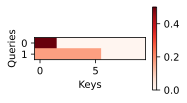

In [10]:
'''
attention.attention_weights:形状：(2, 1, 10)
2：batch_size（2个样本）;1：n_q（每个样本1个查询）;10：n_k（每个查询关注10个键）
.reshape((1, 1, 2, 10))目的：适配d2l.show_heatmaps要求的4D输入格式(batch,num_heads,seq_len,seq_len)
变换后：batch=1：合并为单批次;num_heads=1：单注意力头
seq_len=2：2个样本 → 可视化为2行;seq_len=10：10个键 → 可视化为10列
等效于：将两个样本的注意力权重垂直堆叠成一张热力图
横轴（Keys）：10个键的位置（索引 0-9）
纵轴（Queries）：2个样本的查询（样本0和样本1）
颜色深浅：注意力权重值大小
'''
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

缩放点积注意力

$score(q_{i},k_{j})=\frac{q_{i}\cdot k_{j}^{\top }}{\sqrt{d} } $<br>
为什么需要缩放√d？
- 当维度d很大时，点积的方差会急剧增大
- 导致softmax进入梯度极小的饱和区（类似sigmoid两端）
- 缩放使方差稳定为1，训练更稳定

keys.transpose(1,2)是交换张量的第1维和第2维，在点积注意力中用于将键的特征维度移到最后，以便与查询进行批量矩阵乘法。<br>
**维度变换详解**
假设keys的原始形状：(batch,n_k,d)
- batch：批次大小
- n_k：键的数量（序列长度）
- d：键的特征维度
执行keys.transpose(1,2)后，形状变为：(batch, d, n_k)
```python
原始: [batch, n_k, d]  →  转置后: [batch, d, n_k]
        ^    ^                    ^    ^
        |    |                    |    |
      维度1 维度2                维度1 维度2 (交换)
```
**在注意力机制中的作用**<br>
场景：计算查询和键的点积分数
```python
# queries: (batch, n_q, d)
# keys:    (batch, n_k, d)

scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
# queries:         (batch, n_q, d)
# keys.transpose:  (batch, d, n_k)
# bmm结果:         (batch, n_q, n_k)  ← 注意力分数矩阵
```
**关键**：
queries的d维度必须与keys的d维度对齐才能矩阵乘法<br>
transpose(1,2)将keys重排为(batch,d,n_k)，使得：<br>
queries的每个n_q行（大小为d与keys的每个n_k列（大小为 d）进行点积
**结果** ：每个scores[i,j,k] 表示第i个batch中，第j个查询与第k个键的相似度分数。
**类比：标准矩阵乘法**
在普通矩阵乘法A×B中，要求A的列数等于B的行数。这里：<br>
queries是A(n_q×d)<br>
keys.transpose(1,2)是B(d×n_k)<br>
直观理解：transpose相当于把每个键向量竖起来，以便与查询向量做点积。

In [11]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    # 无需可学习参数，仅有一个dropout层。所有计算都是纯数学运算（矩阵乘法+缩放）
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    # 前向传播：三步流程
    def forward(self, queries, keys, values, valid_lens=None):
        '''
        1. 缩放点积（核心计算）
        queries:(batch,n_q,d)
        keys.transpose(1,2):(batch,d,n_k)
        scores:(batch,n_q,n_k)
        '''
        d = queries.shape[-1] # 查询的维度（如512）
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        # 2. 掩蔽Softmax:支持变长序列，无效位置置零，行归一化
        self.attention_weights = masked_softmax(scores, valid_lens)
        '''
        3. 加权聚合
        attention_weights:(batch,n_q,n_k)
        values:(batch,n_k,v_dim)
        输出:(batch,n_q,v_dim)
        '''
        return torch.bmm(self.dropout(self.attention_weights), values)

演示上述的`DotProductAttention`类

In [12]:
# (batch=2,n_q=1,query_size=2),从标准正态分布N(0,1)采样，每个样本1个查询向量，维度为2
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5) # dropout=0.5
attention.eval() # 评估模式：关闭dropout，推理结果确定
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

均匀的注意力权重

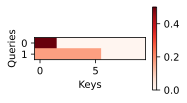

In [13]:
'''
attention.attention_weights形状：(batch=2,n_q=1,n_k=10)
2个样本，每个样本1个查询，每个查询对10个键的注意力分布
.reshape((1,1,2,10))目的：适配d2l.show_heatmaps要求的4D输入格式：
第0维：batch=1（合并为一个批次）
第1维：num_heads=1（单注意力头）
第2维：seq_len=2（将原batch维度展平为序列长度→2行）
第3维：seq_len=10（10列，对应10个键）
等效于：把两个样本的注意力权重垂直拼接成一张2×10的热力图
横轴（Keys）：10个键的位置（索引0-9）
纵轴（Queries）：2个样本的查询（第0行=样本0，第1行=样本1）
颜色深浅：注意力权重值（越亮权重越大）
'''
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')